# Biblioteki

In [5]:
import numpy as np
import pandas as pd
import json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.labelsize'] = '20'
plt.rcParams['legend.fontsize'] = '20'
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Deklaracje

In [7]:
def plot_ts(ts, before=None):
    fig, ax = plt.subplots()
    if before is not None:
        ts_roll_mean = pd.concat([before.iloc[-12:].asfreq('B', method='bfill'), ts]).rolling(window=12).mean()[12:]
        ts_roll_std = pd.concat([before.iloc[-12:].asfreq('B', method='bfill'), ts]).rolling(window=12).std()[12:]
    else:
        ts_roll_mean = ts.rolling(window=12).mean()
        ts_roll_std = ts.rolling(window=12).std()
    
    ts.plot(color='blue', label='Stock return')
    ts_roll_mean.plot(color='red', label="Rolling mean (12-day)")
    ts_roll_std.plot(color='black', label="Rolling std (12-day)")
    
#     ax.set_xticklabels(ts.index)
#     fig.autofmt_xdate()

    plt.tight_layout(pad=1.5)
    plt.tick_params(labelsize='15')
    
    plt.xlabel('Date')
    plt.ylabel('Stock return')
    plt.legend()
    plt.show()
    
def perform_dft(ts):
    #Perform Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(ts, autolag='t-stat')
    add_col = []
    values = list(dftest[0:4])
    for key,value in dftest[4].items():
        add_col.append('Critical Value (%s)'%key)
        values.append(value)

    dfoutput = pd.DataFrame(data = [values], index=['Value'], columns=['Test Statistic','p-value','#Lags Used','Number of Observations Used']+add_col)
    display(dfoutput)

def decompose(ts):
    decomposition = seasonal_decompose(ts, freq=10) 
    decomposition.plot()
    plt.show()
    
def find_best_hparameters(ts, pmax, d, qmax):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for p in range(pmax+1):
        for q in range(qmax+1):
            order = (p,d,q)
            try:
                model = ARIMA(ts, order=order, freq='B')
                results = model.fit()
                rmse_value = rmse(results.fittedvalues, ts)
                rmse_value_list.append(rmse_value)
                order_list.append(order)
            except Exception as e:
                errors_dict[str(order)] = {'error_str': str(e)}
    
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best10 = tuple(order for order, rmse_value in results[:10])
    return best10, results

def select_best_orders_from_best10(ts, best10):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in best10:
        try:
            model = ARIMA(ts, order=order, freq='B')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def test_orders(ts, orders):
    errors_dict = {}
    rmse_value_list = []
    order_list = []
    for order in orders:
        try:
            model = ARIMA(ts, order=order, freq='B')
            results = model.fit()
            rmse_value = rmse(results.fittedvalues, ts)
            rmse_value_list.append(rmse_value)
            order_list.append(order)
        except Exception as e:
            errors_dict[str(order)] = {'error_str': str(e)}
            
    errors = pd.DataFrame.from_dict(errors_dict, orient='index')
    display(errors)
    
    results = sorted([(order, rmse_value) for order, rmse_value in zip(order_list, rmse_value_list)], key = lambda x: x[1])
    best = results[0][0]
    return best, results

def show_est_plot(ts, order=None, zero=False, naiwny=False, label="Wykres"):
    if zero == True:
        z = [0]*len(ts)
        rmse_value = rmse(ts, z)
        plt.plot(ts.index, z, label="Zero", color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    elif naiwny == True:
        rmse_value = rmse(ts[1:], ts.shift()[1:])
        plt.plot(ts[1:].index, ts.shift()[1:], label="Naiwny", color='red')
        plt.plot(ts[1:].index, ts[1:], label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
    else:
        model = ARIMA(ts, order=order, freq='B')
        results = model.fit()
        rmse_value = rmse(results.fittedvalues, ts)
        plt.plot(ts.index, results.fittedvalues, label=label, color='red')
        plt.plot(ts.index, ts, label=label, color='blue')
        plt.title(f'{label} (RMSE: {rmse_value})')
        plt.show()
        

In [8]:
best_results = {}

# Wczytanie zbiorów

In [43]:
train = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/train_ekon.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid1_ekon.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid2_ekon.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/valid3_ekon.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ekonometryczne/wszystkie/test_ekon.csv', index_col=0)
index0 = pd.concat([val1, val2, val3]).index

train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)

whole = pd.concat([train, val1, val2, val3, test]).asfreq('B', method='bfill').fillna(method='bfill')

train1 = train.asfreq('B', method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill')

val1 = val1.asfreq('B', method='bfill')
val2 = val2.asfreq('B', method='bfill')
val3 = val3.asfreq('B', method='bfill')
test = test.asfreq('B', method='bfill')
test_index1 = test.index

In [10]:
display(train.head(3))
display(val1.head(3))
display(val2.head(3))
display(val3.head(3))
display(test.head(3))
display(whole.head(3))

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

,return ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,PPO,AROONOSC,BOP,MINUS_DM,ULTOSC,AD,OBV,DEMA,HT_TRENDLINE,KAMA,MIDPOINT,MIDPRICE,SAR,SAREXT,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,CMO,MINUS_DI,PLUS_DI,ROC,ROCP,ROCR,ROCR100,ADOSC,NATR,TRANGE,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE,HT_DCPERIOD,HT_DCPHASE,HT_TRENDMODE,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,CDL3WHITESOLDIERS,CDLABANDONEDBABY,CDLADVANCEBLOCK,CDLBELTHOLD,CDLBREAKAWAY,CDLCLOSINGMARUBOZU,CDLCONCEALBABYSWALL,CDLCOUNTERATTACK,CDLDARKCLOUDCOVER,CDLDOJI,CDLDOJISTAR,CDLDRAGONFLYDOJI,CDLENGULFING,CDLEVENINGDOJISTAR,CDLEVENINGSTAR,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLHIKKAKEMOD,CDLHOMINGPIGEON,CDLIDENTICAL3CROWS,CDLINNECK,CDLINVERTEDHAMMER,CDLKICKING,CDLKICKINGBYLENGTH,CDLLADDERBOTTOM,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLMATHOLD,CDLMORNINGDOJISTAR,CDLMORNINGSTAR,CDLONNECK,CDLPIERCING,CDLRICKSHAWMAN,CDLRISEFALL3METHODS,CDLSEPARATINGLINES,CDLSHOOTINGSTAR,CDLSHORTLINE,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,TSF,VAR,ADD,DIV,MAX,MAXINDEX,MIN,MININDEX,MULT,SUB,SUM,ATAN,CEIL,COS,COSH,EXP,FLOOR,LN,LOG10,SIN,SINH,SQRT,TAN,TANH,current ratio,long-term debt/capital,debt/equity ratio,gross_margin,operating_margin,ebig margin,pre-tax profit margin,net_profit_margin,asset_turnover,inventory_turnover_ratio,receiveable_turnover,days_sales_in_receivables,roe,return on tangible equity,roa,roi,book value per share,operating cash flow per share,free cash flow per share,nvidia_,GeForce_,gtx_,GPU_,AMD_,Intel_,deep learning_,Artificial Intelligence_,Machine Learning_,neural network_,Data Science_,natural language processing_,fintech_,Azure_,AWS_,Google Cloud_,TensorFlow_,PyTorch_,MXNet_,blockchain_,cryptocurrency_,bitcoin_,ethereum_,Bitcoin miner_,cryptocurrency miner_,gaming_,e-sport_,Battlefield_,Just Cause_,Assassin's Creed_,Hitman_,Far Cry_,Final Fantasy_,Forza Motorsport_,Call of Duty_,Witcher_,Fallout_,gaming PC_,Nvidia Shield_,GTA_,Python_,Twitch_,nvidia_news,gtx_news,GPU_news,AMD_news,deep learning_news,Artificial Intelligence_news,Data Science_news,fintech_news,AWS_news,blockchain_news,bitcoin_news,ethereum_news,gaming_news,e-sport_news,Battlefield_news,Just Cause_news,Assassin's Creed_news,Hitman_news,Far Cry_news,Final Fantasy_news,Forza Motorsport_news,Call of Duty_news,Witcher_news,Fallout_news,gaming PC_news,nvidia__scaled,GeForce__scaled,gtx__scaled,GPU__scaled,AMD__scaled,Intel__scaled,deep learning__scaled,Artificial Intelligence__scaled,Machine Learning__scaled,neural network__scaled,Data Science__scaled,natural language processing__scaled,fintech__scaled,Azure__scaled,AWS__scaled,Google Cloud__scaled,MXNet__scaled,Bitcoin miner__scaled,gaming__scaled,e-sport__scaled,Battlefield__scaled,Just Cause__scaled,Assassin's Creed__scaled,Hitman__scaled,Far Cry__scaled,Final Fantasy__scaled,Forza Motorsport__scaled,Call of Duty__scaled,Witcher__scaled,Fallout__scaled,gaming PC__scaled,GTA__scaled,Python__scaled,Twitch__scaled,nvidia_news_scaled,gtx_news_scaled,GPU_news_scaled,AMD_news_scaled,Artificial Intelligence_news_scaled,AWS_news_scaled,gaming_news_scaled,Battlefield_news_scaled,Just Cause_news_scaled,Assassin's Creed_news_scaled,Hitman_news_scaled,Far Cry_news_scaled,Final Fantasy_news_scaled,Forza Motorsport_news_scaled,Call of Duty_news_scaled,Witcher_news_scaled,Fallout_news_scaled,gaming PC_news_scaled,arxiv,BTC,AMD,SandP,NasdaqTech,ATVI_gaming,TTWO_gaming,UBSFY_gaming,super_gry,fps,"NVIDIA_news_publikacja_(0, 1]","NVIDIA_news_publikacja_(1, 3]","NVIDIA_news_publikacja_(3, 6]","NVIDIA_news_publikacja_(6, 100]","NVIDIA_news_inni_o_nich_pisza_(0, 1]","NVIDIA_news_inni_o_nich_pisza_(1, 3]","NVIDIA_news_inni_o_nich_pisza_(3, 6]","ogloszenie_nowej_karty_(0, 1]"

In [10]:
acorr_ljungbox(val3['return ratio'])

(array([ 0.55904573,  9.2191203 ,  9.243737  ,  9.90676045,  9.94023523,
        10.5186833 , 11.33992285, 11.44468993, 11.48251051, 11.49024635,
        12.64772713, 13.29863476, 14.35095659, 14.58279246, 16.1593614 ,
        16.30216447, 16.40312284, 16.44435133, 17.7495294 , 17.87593238]),
 array([0.45464499, 0.0099562 , 0.0262198 , 0.04202792, 0.07694647,
        0.10444074, 0.1244637 , 0.17775259, 0.24407852, 0.32061893,
        0.31697177, 0.34771349, 0.34960036, 0.40725486, 0.3715402 ,
        0.43207822, 0.49545831, 0.56156604, 0.53922308, 0.59558096]))

# Testy stacjonarności

## Trening 1

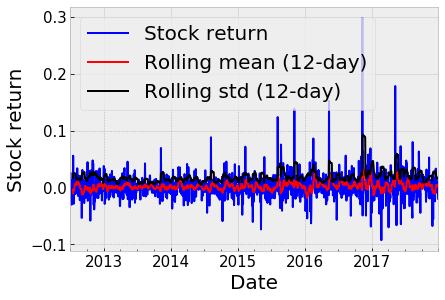

In [ ]:
y_train = train1['return ratio']
y_valid = val1['return ratio']
plot_ts(y_train)

In [ ]:
perform_dft(y_train)

Results of Dickey Fuller Test:


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Value,-10.580198,6.937380e-19,13,1421,-3.43496,-2.863576,-2.567854


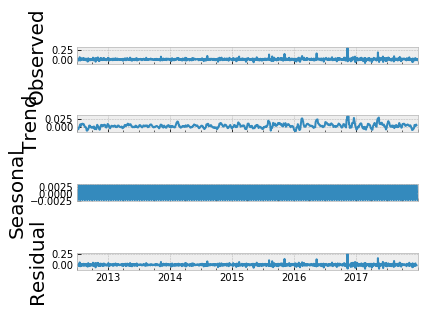

In [ ]:
decompose(y_train)

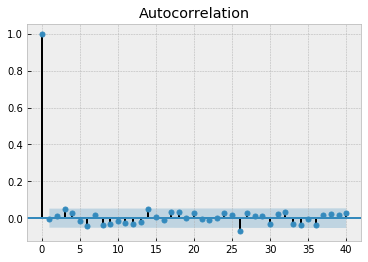

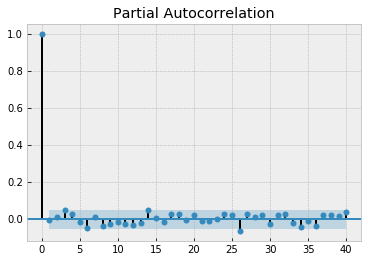

In [ ]:
plot_acf(y_train, lags=40, alpha=0.05)
plot_pacf(y_train, lags=40, alpha=0.05)
plt.show()

In [ ]:
pmax = 3
qmax = 3
d = 0

best10, results = find_best_hparameters(y_train, pmax=pmax, qmax=qmax, d=d)
print(best10)
print(results)
print('####################################################################')
best, results = select_best_orders_from_best10(y_valid, best10)
best_results['train1'] = results
print(best)
print(results)

/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

,error_str
"(1, 0, 1)",The computed initial AR coefficients are not s...
"(1, 0, 2)",The computed initial AR coefficients are not s...
"(1, 0, 3)",The computed initial AR coefficients are not s...
"(2, 0, 2)",The computed initial AR coefficients are not s...
"(2, 0, 3)",The computed initial AR coefficients are not s...
"(3, 0, 3)",The computed initial AR coefficients are not s...


((3, 0, 2), (3, 0, 1), (0, 0, 3), (3, 0, 0), (2, 0, 1), (0, 0, 2), (2, 0, 0), (1, 0, 0), (0, 0, 1), (0, 0, 0))
[((3, 0, 2), 0.021808092461653678), ((3, 0, 1), 0.021822434317838254), ((0, 0, 3), 0.02182285737846077), ((3, 0, 0), 0.02182614757033817), ((2, 0, 1), 0.021842859340028796), ((0, 0, 2), 0.021854099293925663), ((2, 0, 0), 0.021854110086464), ((1, 0, 0), 0.021856077882791296), ((0, 0, 1), 0.021856080906185817), ((0, 0, 0), 0.021856192160481003)]
####################################################################


""


(3, 0, 2)
[((3, 0, 2), 0.02613230895259504), ((0, 0, 3), 0.02634119355415954), ((3, 0, 1), 0.026481769310924892), ((3, 0, 0), 0.026482033461889723), ((2, 0, 1), 0.02686502960696172), ((2, 0, 0), 0.027495976292254712), ((0, 0, 1), 0.027585195102667298), ((0, 0, 2), 0.027585326793151687), ((1, 0, 0), 0.027607068363375967), ((0, 0, 0), 0.027835193948737916)]


## Trening 2

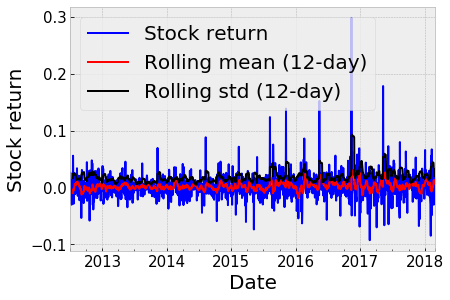

In [ ]:
y_train = train2['return ratio']
y_valid = val2['return ratio']
plot_ts(y_train)

In [ ]:
perform_dft(y_train)

Results of Dickey Fuller Test:


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Value,-10.649285,4.706619e-19,13,1464,-3.434825,-2.863516,-2.567822


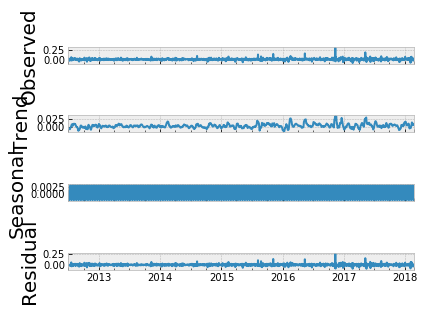

In [ ]:
decompose(y_train)

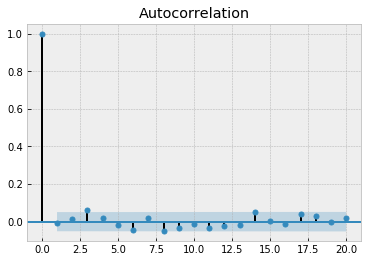

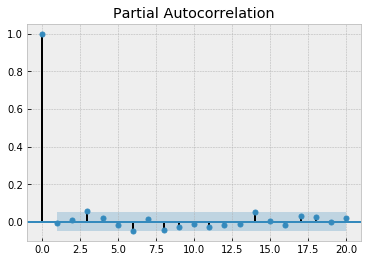

In [ ]:
plot_acf(y_train, lags=20, alpha=0.05)
plot_pacf(y_train, lags=20, alpha=0.05)
plt.show()

In [ ]:
pmax = 3
qmax = 3
d = 0

best10, results = find_best_hparameters(y_train, pmax=pmax, qmax=qmax, d=d)
print(best10)
print(results)
print('###############################################')
best, results = select_best_orders_from_best10(y_valid, best10)
best_results['train2'] = results
print(best)
print(results)

/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

## Trening 3

In [ ]:
y_train = train3['return ratio']
y_valid = val3['return ratio']
plot_ts(y_train)

In [ ]:
perform_dft(y_train)

In [ ]:
decompose(y_train)

In [ ]:
plot_acf(y_train, lags=20, alpha=0.05)
plot_pacf(y_train, lags=20, alpha=0.05)
plt.show()

In [ ]:
pmax = 3
qmax = 3
d = 0

best10, results = find_best_hparameters(y_train, pmax=pmax, qmax=qmax, d=d)
print(best10)
print(results)
print('########################################')
best, results = select_best_orders_from_best10(y_valid, best10)
best_results['train3'] = results
print(best)
print(results)

## Wyniki selekcji

In [ ]:
print(best_results['train1'])

In [ ]:
print(best_results['train2'])

In [ ]:
print(best_results['train3'])

In [ ]:
rmse_values_dict = {}
for k, results in best_results.items():
    for order, rmse_value in results:
        rmse_values_dict[order] = [rmse_value] if order not in rmse_values_dict else rmse_values_dict[order] + [rmse_value]

        
chosen_one_list = []
for k, v in rmse_values_dict.items():
    if len(v) == 3:
        chosen_one_list.append((k, np.mean(v)))
        
chosen_one_list.sort(key=lambda x: x[1])
chosen_one_list

# Testowanie

In [8]:
y_test = test['return ratio']
best_of_the_best, results = test_orders(y_test, [order for order, rmse_value in chosen_one_list])
print(results)

NameError: name 'chosen_one_list' is not defined

In [9]:
show_est_plot(y_test, best_of_the_best, label=best_of_the_best)
show_est_plot(y_test, (1, 0, 0), label=(1, 0, 0))
show_est_plot(y_test, zero=True, label="Zero")
show_est_plot(y_test, naiwny=True, label="Naiwny")

NameError: name 'best_of_the_best' is not defined

# Estymacja na walidacji i teście

## Walidacja

In [29]:
order = (0,0,0)
y_train = train1['return ratio']
y_test = pd.concat([val1, val2, val3]).asfreq('B', method='bfill')['return ratio']
period = pd.concat([y_train, y_test])

In [30]:
model = SARIMAX(y_train, order=order, trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:           return ratio   No. Observations:                 1435
Model:                        SARIMAX   Log Likelihood                3450.217
Date:                Sun, 14 Apr 2019   AIC                          -6896.434
Time:                        18:07:49   BIC                          -6885.896
Sample:                    07-02-2012   HQIC                         -6892.500
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.001      3.416      0.001       0.001       0.003
sigma2         0.0005   5.03e-06     94.997      0.000       0.000       0.000
Ljung-Box (Q):                       46.64   Jarque-

/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

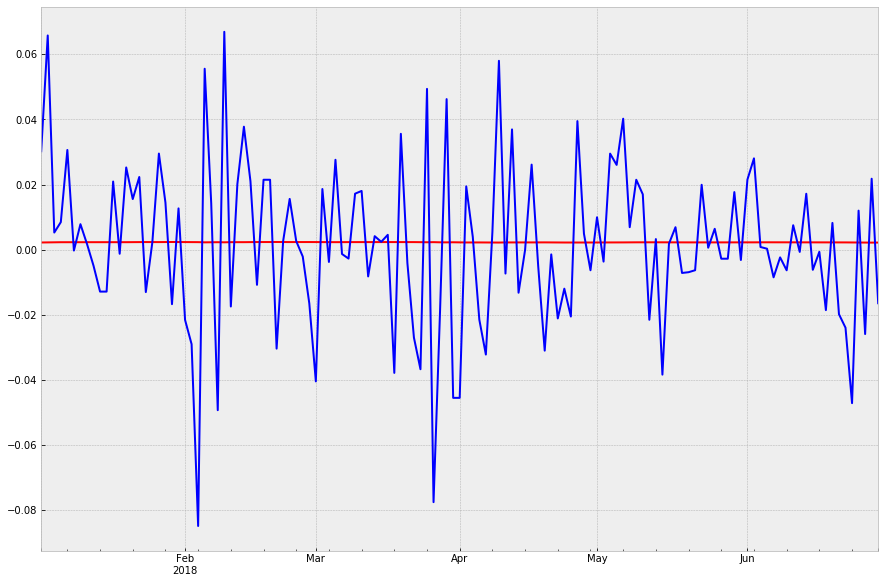

In [31]:
forecasts = []
for i in range(len(y_test)):
    y_train = pd.concat([train1['return ratio'], y_test[:i]]).asfreq('B', method='bfill')
    model = ARIMA(y_train, order=order, freq='B')
    results = model.fit()
    forecasts.append(results.forecast()[0][0])
forecasts = pd.Series(forecasts, index=y_test.index)
forecasts.plot(color='red', label='Forecast')
y_test.plot(color='blue', label='Real')
plt.show()

In [35]:
forecasts.values

array([0.00221561, 0.00225461, 0.00229881, 0.00230087, 0.00230516,
       0.00232482, 0.00232302, 0.00232685, 0.00232647, 0.00232147,
       0.00231096, 0.00230047, 0.00231334, 0.00231089, 0.00232671,
       0.00233583, 0.00234961, 0.00233903, 0.00233903, 0.00235772,
       0.00236603, 0.00235293, 0.00236002, 0.00234362, 0.00232214,
       0.00226245, 0.00229893, 0.00230712, 0.00227186, 0.002316  ,
       0.00230252, 0.0023147 , 0.00233886, 0.0023516 , 0.00234266,
       0.00235567, 0.00236867, 0.00234643, 0.00234664, 0.00235563,
       0.00235582, 0.0023528 , 0.00234004, 0.00231111, 0.00232215,
       0.00231804, 0.00233511, 0.00233265, 0.00232924, 0.00233926,
       0.00234983, 0.00234273, 0.00234395, 0.002344  , 0.0023455 ,
       0.00231854, 0.00234085, 0.00233654, 0.00231691, 0.0022908 ,
       0.00232229, 0.00226894, 0.00225508, 0.00228443, 0.00225257,
       0.00222075, 0.00223222, 0.00223336, 0.0022176 , 0.00219472,
       0.00219686, 0.00223391, 0.00222757, 0.00225058, 0.00224

In [36]:
len(forecasts)

129

In [32]:
print(rmse(y_test, forecasts))
print(rmse(y_test, [0]*len(y_test)))

0.02525729951984102
0.025289496364816706


## Test

In [43]:
order = (0,0,0)
train_set = pd.concat([train, val1, val2, val3]).asfreq('B', method='bfill')
y_train = train_set['return ratio']
y_test = test['return ratio']
period = pd.concat([y_train, y_test])

In [44]:
model = SARIMAX(y_train, order=order, trend='c')
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:           return ratio   No. Observations:                 1565
Model:                        SARIMAX   Log Likelihood                3741.183
Date:                Sun, 14 Apr 2019   AIC                          -7478.366
Time:                        18:24:47   BIC                          -7467.655
Sample:                    07-02-2012   HQIC                         -7474.384
                         - 06-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.001      3.531      0.000       0.001       0.003
sigma2         0.0005   5.17e-06     95.005      0.000       0.000       0.001
Ljung-Box (Q):                       60.32   Jarque-

/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/michal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


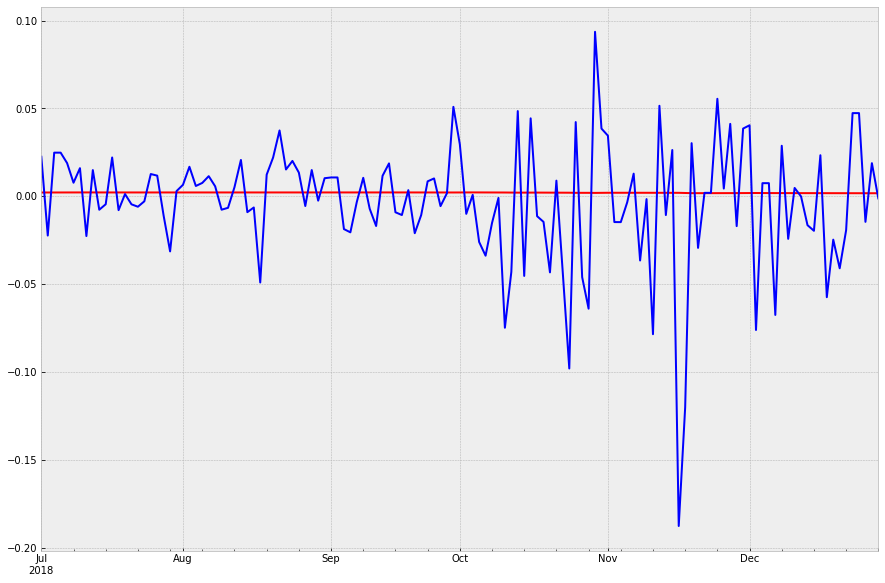

In [45]:
forecasts = []
for i in range(len(y_test)):
    y_train = pd.concat([train_set['return ratio'], y_test[:i]]).asfreq('B', method='bfill')
    model = SARIMAX(y_train, order=order, trend='c', enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    forecasts.append(results.forecast()[0])
forecasts = pd.Series(forecasts, index=y_test.index)
forecasts.plot(color='red', label='Forecast')
y_test.plot(color='blue', label='Real')
plt.show()

In [46]:
print(rmse(y_test, forecasts))

0.035559909237932494


In [50]:
forecasts.values

array([0.0021939 , 0.0022069 , 0.00219126, 0.00220572, 0.00222017,
       0.00223084, 0.00223436, 0.00224315, 0.00222735, 0.00223543,
       0.00222918, 0.00222491, 0.00223753, 0.00223113, 0.00223054,
       0.00222626, 0.00222112, 0.00221794, 0.00222456, 0.0022306 ,
       0.0022222 , 0.00220105, 0.00220154, 0.00220429, 0.00221351,
       0.00221583, 0.00221924, 0.00222507, 0.00222726, 0.0022211 ,
       0.00221562, 0.0022175 , 0.0022291 , 0.00222207, 0.00221672,
       0.00218467, 0.00219101, 0.00220345, 0.00222548, 0.00223363,
       0.0022448 , 0.00225183, 0.00224699, 0.00225491, 0.00225199,
       0.002257  , 0.00226228, 0.00226755, 0.0022546 , 0.00224051,
       0.00223716, 0.00224231, 0.00223657, 0.00222476, 0.00223061,
       0.00224082, 0.00223385, 0.00222592, 0.00222673, 0.00221244,
       0.00220453, 0.00220842, 0.00221333, 0.00220856, 0.0022083 ,
       0.00223821, 0.00225504, 0.00224756, 0.00224671, 0.00222944,
       0.00220741, 0.00219679, 0.00219491, 0.0021479 , 0.00212

In [48]:
len(forecasts)

131

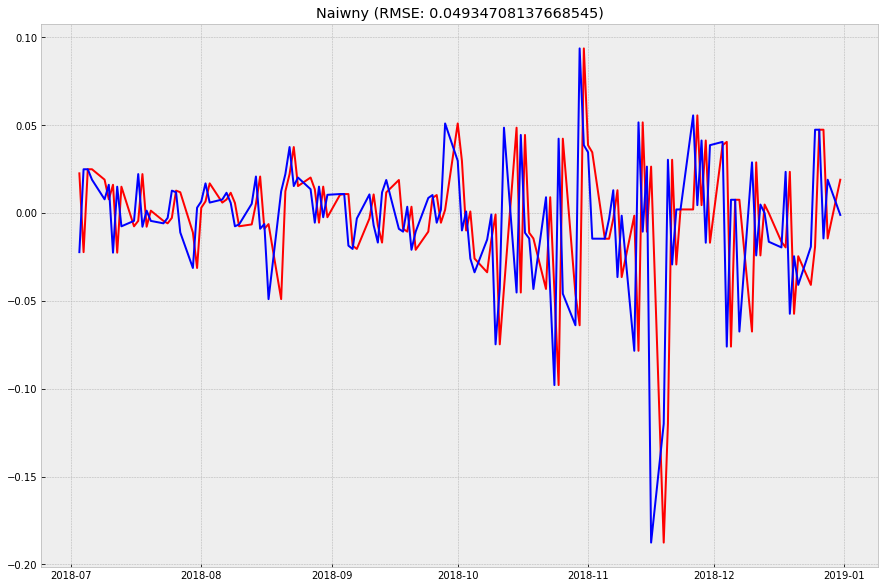

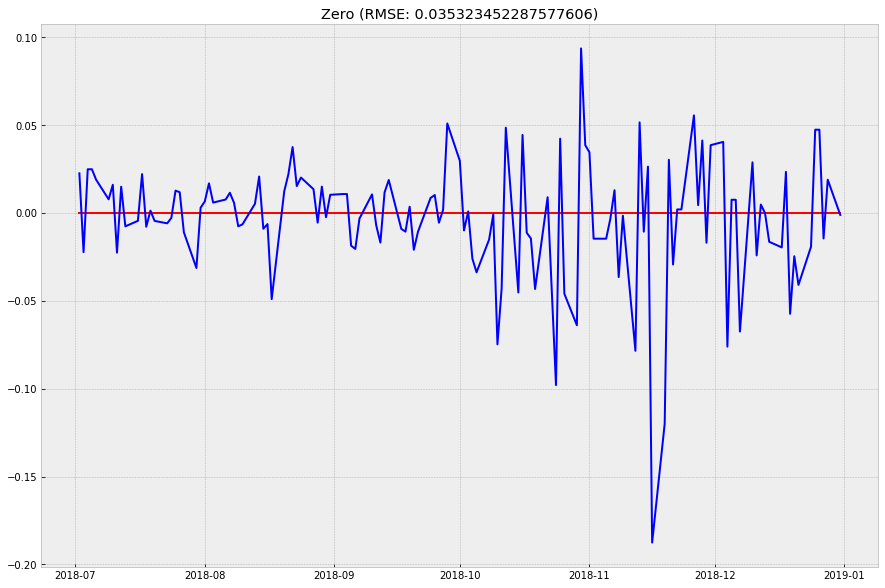

/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/michal/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

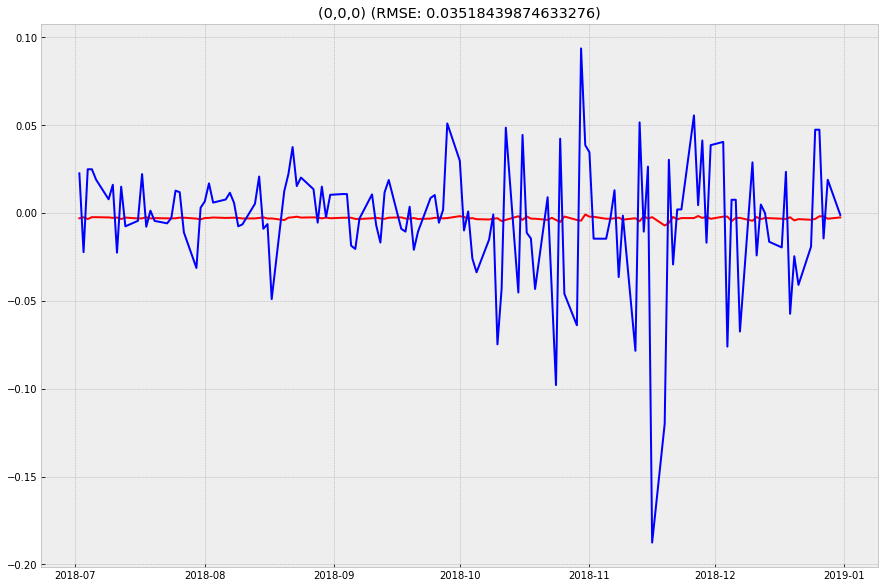

In [23]:
show_est_plot(y_test, naiwny=True, label='Naiwny')
show_est_plot(y_test, zero=True, label='Zero')
show_est_plot(y_test, order=(1,0,0), label='(0,0,0)')

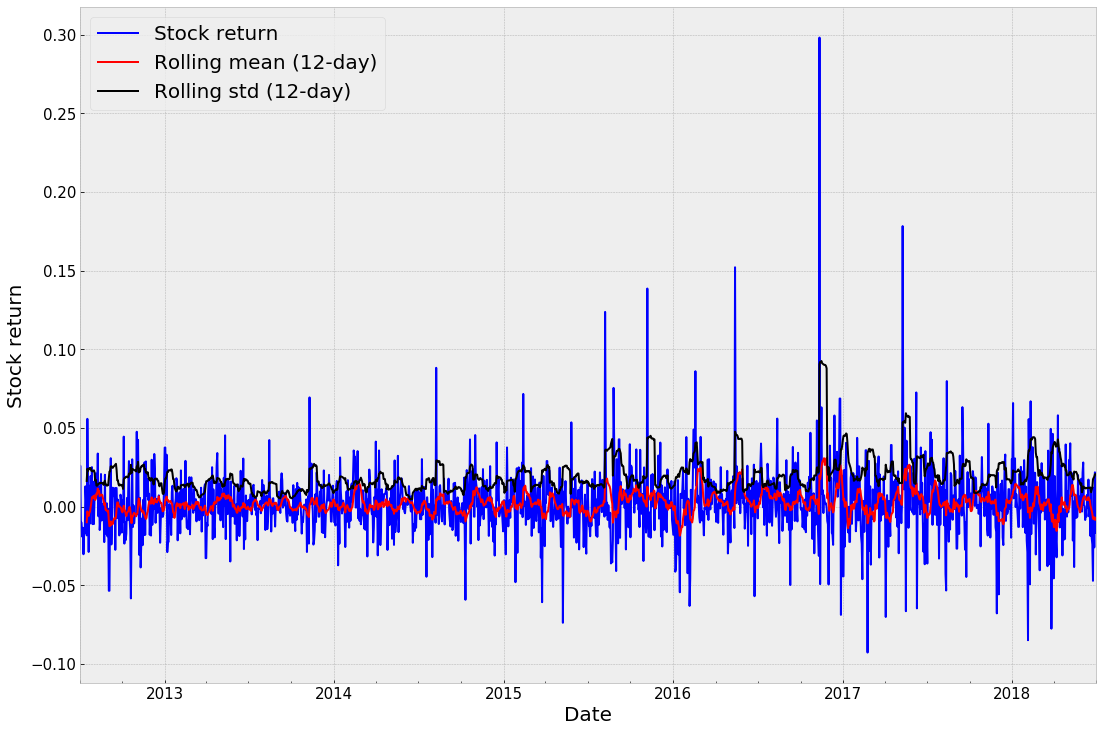

In [116]:
train_plus_val = pd.concat([train, val1, val2, val3]).asfreq('B', method='bfill')['return ratio']
plot_ts(train_plus_val)

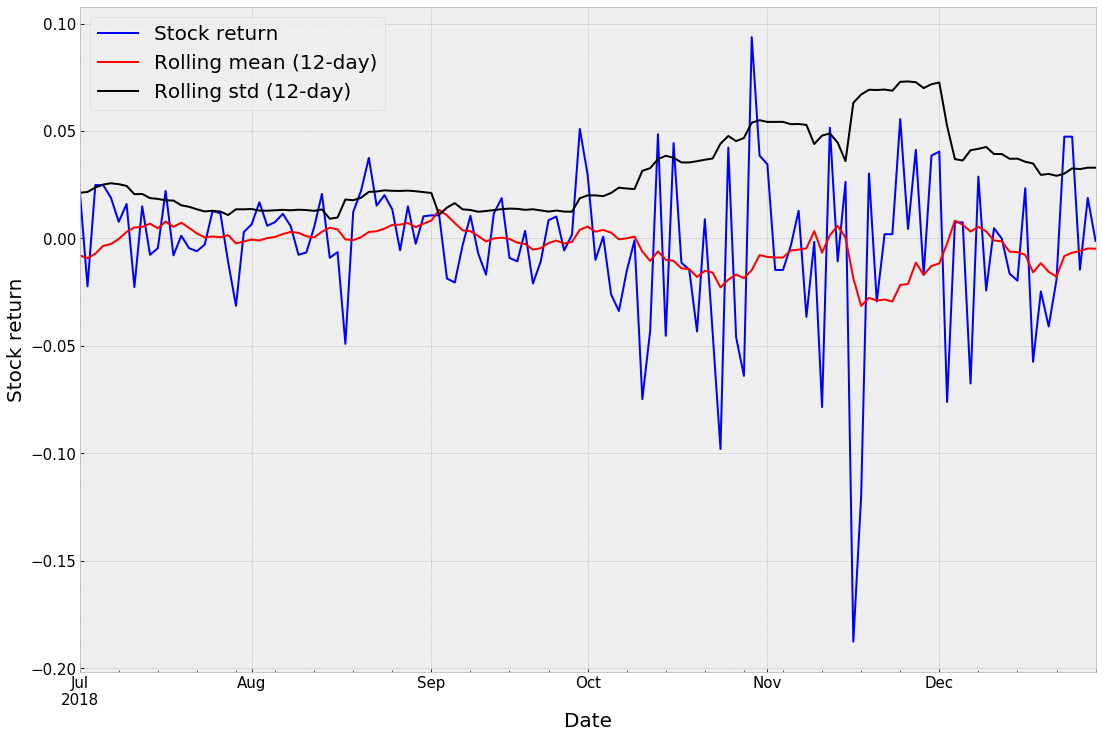

In [115]:
plot_ts(test['return ratio'], val3['return ratio'])

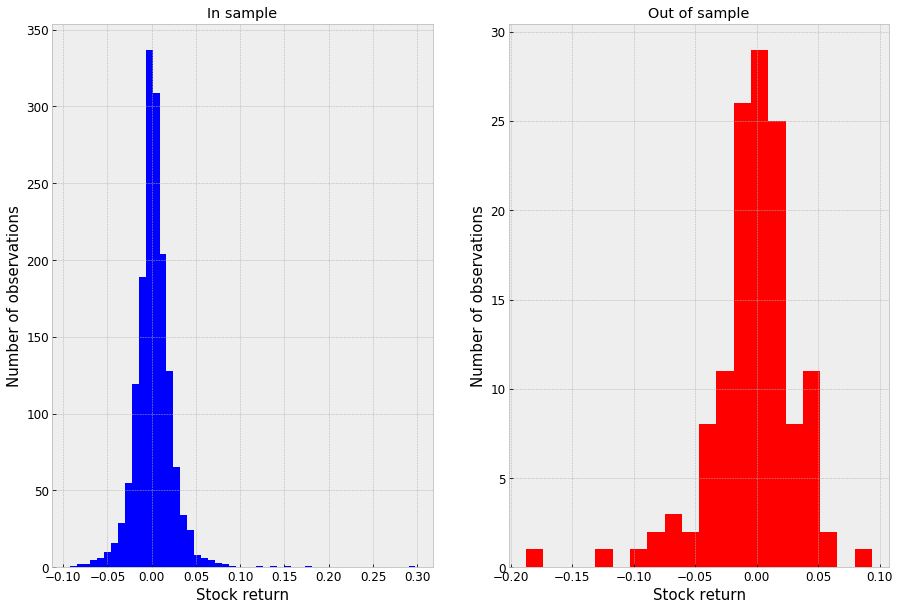

In [144]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(train_plus_val, bins=50, color='blue')
ax[0].set_ylabel('Number of observations', fontsize=15)
ax[0].set_xlabel('Stock return', fontsize=15)
ax[0].set_title('In sample')
ax[0].tick_params(labelsize=12)
ax[1].hist(test['return ratio'], bins=20, color='red')
ax[1].set_ylabel('Number of observations', fontsize=15)
ax[1].set_xlabel('Stock return', fontsize=15)
ax[1].set_title('Out of sample')
ax[1].tick_params(labelsize=12)

# train_plus_val.hist(color='blue', bins=100, ax=ax[0])
# test['return ratio'].hist(color='red', bins=100)

In [276]:
perform_dft(train_plus_val)

Results of Dickey Fuller Test:


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Value,-11.013589,6.236654e-20,13,1551,-3.434573,-2.863405,-2.567763


In [274]:
perform_dft(test['return ratio'])

Results of Dickey Fuller Test:


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Value,-11.085148,4.215051e-20,0,130,-3.481682,-2.884042,-2.57877


([<matplotlib.axis.YTick at 0x7feeab252898>,
 <a list of 21 Text yticklabel objects>)

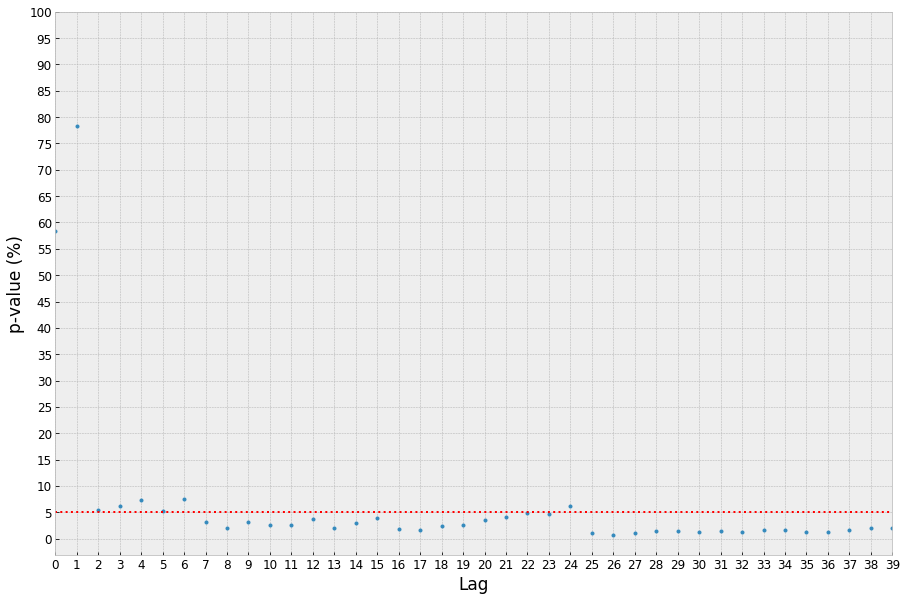

In [269]:
seriatest = (pd.Series(acorr_ljungbox(train_plus_val)[1])*100)
seriatest.plot(style='.')
plt.axhline(y=5, color='r', linestyle=':')
plt.ylabel('p-value (%)', fontsize=17)
plt.xlabel('Lag', fontsize=17)
plt.tick_params(labelsize=12)
plt.xticks([x for x in range(len(seriatest))])
plt.yticks([5*x for x in range(21)])

([<matplotlib.axis.YTick at 0x7feea67e4978>,
 <a list of 21 Text yticklabel objects>)

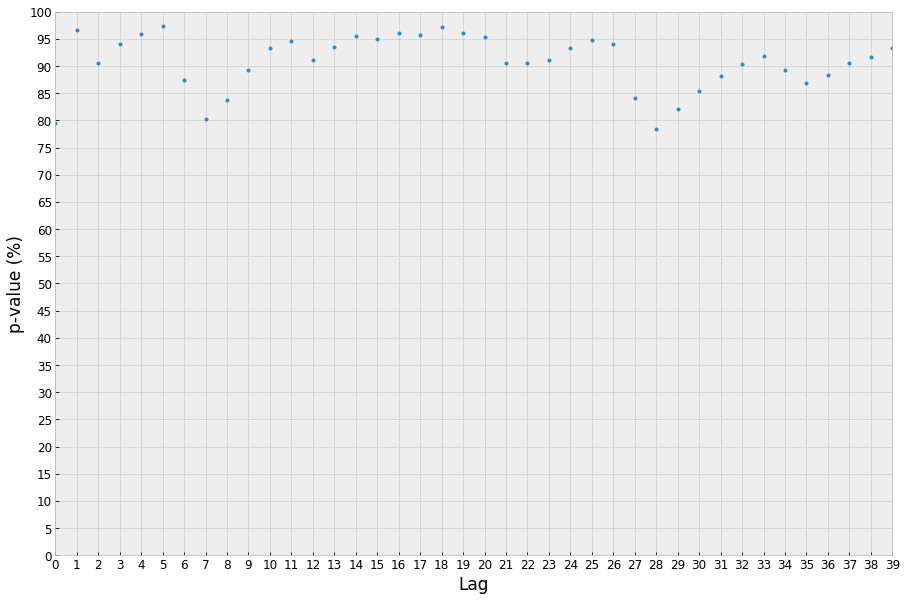

In [222]:
seriatest2 = (pd.Series(acorr_ljungbox(test['return ratio'])[1])*100)
seriatest2.plot(style='.')
plt.ylabel('p-value (%)', fontsize=17)
plt.xlabel('Lag', fontsize=17)
plt.tick_params(labelsize=12)
plt.xticks([x for x in range(len(seriatest))])
plt.yticks([5*x for x in range(21)])

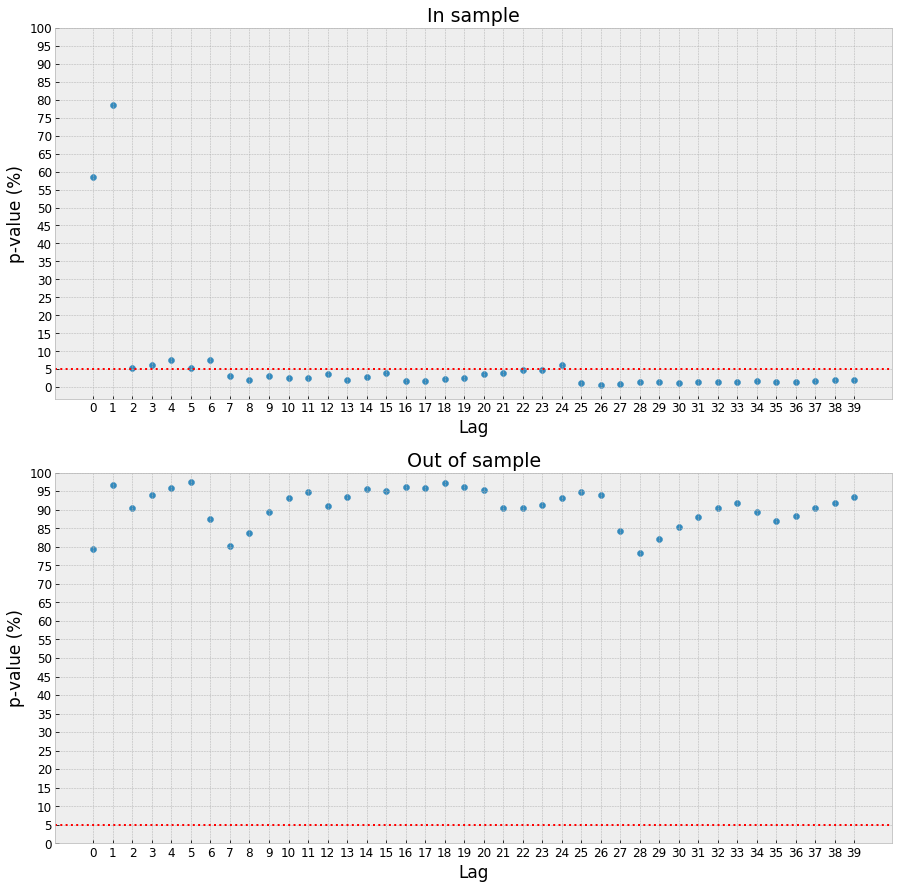

In [273]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].scatter(seriatest.index, seriatest)
ax[0].set_xlabel('Lag', fontsize=17)
ax[0].set_ylabel('p-value (%)', fontsize=17)
ax[0].set_xticks([x for x in range(len(seriatest))])
ax[0].set_yticks([x*5 for x in range(21)])
ax[0].set_title('In sample', fontsize=19)
ax[0].axhline(5, linestyle=":", color='red')
ax[0].tick_params(labelsize=12)
ax[1].scatter(seriatest2.index, seriatest2)
ax[1].set_xlabel('Lag', fontsize=17)
ax[1].set_ylabel('p-value (%)', fontsize=17)
ax[1].set_xticks([x for x in range(len(seriatest))])
ax[1].set_yticks([x*5 for x in range(21)])
ax[1].set_title('Out of sample', fontsize=19)
ax[1].axhline(5, linestyle=":", color='red')
ax[1].tick_params(labelsize=12)

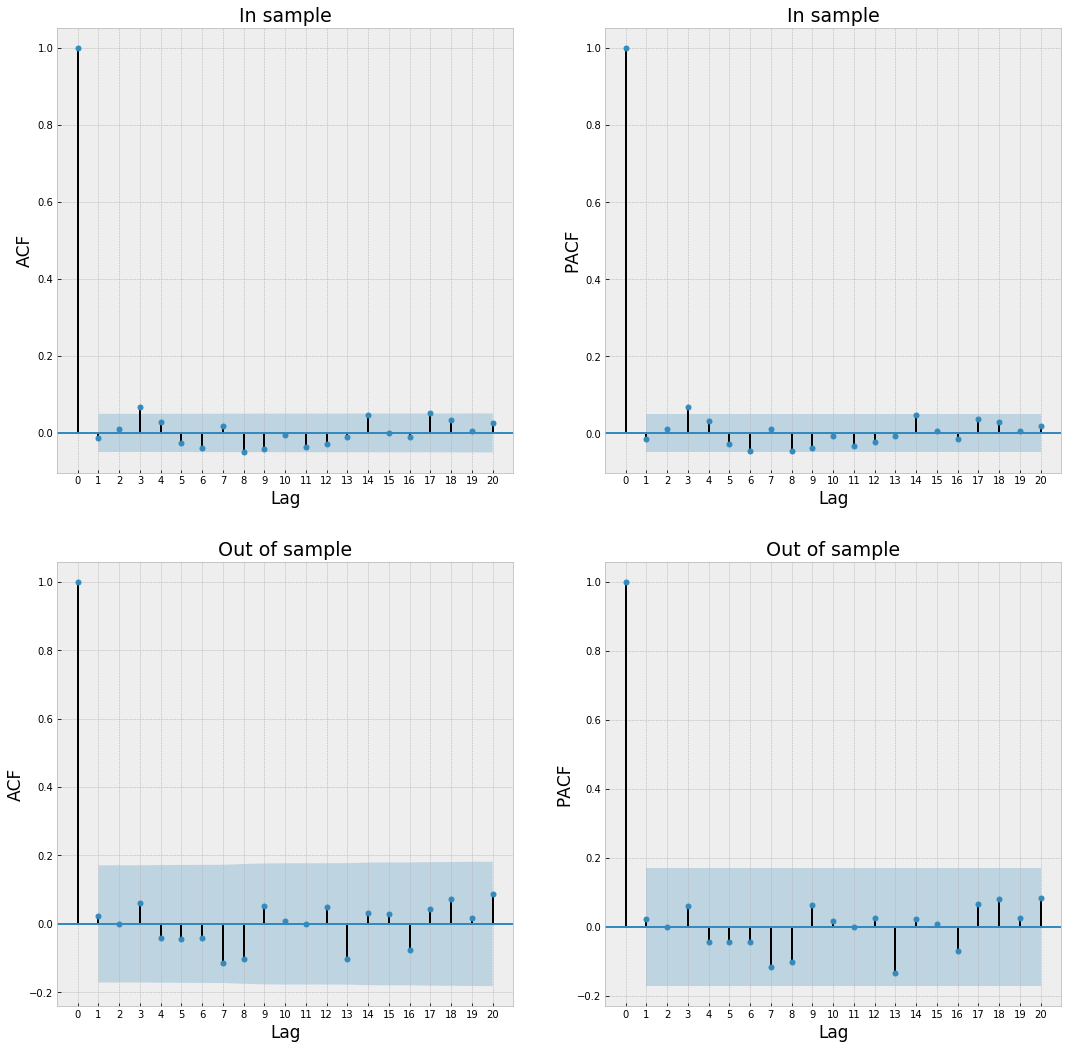

In [277]:
fig, ax = plt.subplots(2,2, figsize=(18, 18))
plot_acf(train_plus_val, lags=20, ax=ax[0, 0])
ax[0,0].set_xticks([x for x in range(21)])
ax[0,0].set_xlabel('Lag', fontsize=17)
ax[0,0].set_ylabel('ACF', fontsize=17)
ax[0,0].set_title('In sample', fontsize=19)
plot_pacf(train_plus_val, lags=20, ax=ax[0, 1])
ax[0,1].set_xticks([x for x in range(21)])
ax[0,1].set_xlabel('Lag', fontsize=17)
ax[0,1].set_ylabel('PACF', fontsize=17)
ax[0,1].set_title('In sample', fontsize=19)
plot_acf(test['return ratio'], lags=20, ax=ax[1, 0])
ax[1,0].set_xticks([x for x in range(21)])
ax[1,0].set_xlabel('Lag', fontsize=17)
ax[1,0].set_ylabel('ACF', fontsize=17)
ax[1,0].set_title('Out of sample', fontsize=19)
plot_pacf(test['return ratio'], lags=20, ax=ax[1, 1])
ax[1,1].set_xticks([x for x in range(21)])
ax[1,1].set_xlabel('Lag', fontsize=17)
ax[1,1].set_ylabel('PACF', fontsize=17)
ax[1,1].set_title('Out of sample', fontsize=19)

plt.show()

In [51]:
forecasts_test = [-0.0045807813, -0.0014651576, 0.011698445, 0.006832683, 0.0025247058, -0.00060910487, -0.0004875707, -0.025681887, 0.0070728064, 0.005505967, -0.004711798, 0.006699631, 0.030827427, -0.0022201475, 0.0068411254, 0.011953812, -0.0102746235, 0.009257773, -0.0066065216, 0.010553011, 0.0015440261, -0.02380505, -0.0021957986, 0.005104398, 0.020250188, 0.0026251716, -0.01969646, 0.0053362832, 0.0032619901, 0.036549244, -0.0059957197, -0.0028241167, 0.014692016, 0.008380628, 0.006398982, 0.039907105, 0.007196579, 0.006048787, -0.010308532, 0.0014186185, -0.00095343695, -0.012930633, -0.0028371834, 0.021708298, -0.020242848, 0.0034001707, 0.0016508977, -0.006503806, 0.009694918, -0.0038823267, 0.004853189, -0.004953414, 0.02088654, 0.010272039, 0.012661006, -0.008795749, -0.011687755, -0.025441954, -0.0020074793, 0.013023259, 0.004727892, -0.00279672, 0.009072512, 0.016890155, -0.003289684, 0.0034693994, 0.0003000962, 0.0071144053, -0.00047472573, 0.01094977, 0.0029978366, 0.0050121997, 0.010659206, 0.011056436, -0.009175236, -0.0063635143, 0.005417099, 0.018182643, 0.0032393222, -0.0031850475, 0.0022076853, -0.009023024, -0.0056098853, -0.0076063783, -0.025003752, -0.0222487, 0.000663028, 0.0018833899, 0.052520033, 0.014718329, 0.0015317835, -0.0019083224, -0.0011903419, 0.010343816, -0.00027854112, 0.024083707, -0.008222289, 0.0046300427, -0.009810959, -0.018987495, 0.0060818195, 0.005231372, 0.0032737548, 0.0064929165, -0.0035285188, -0.0049820254, -0.024164472, -0.004690276, -0.00047666475, -0.0066084173, -0.009486215, -0.025289625, 0.024667017, 0.0029231852, 0.01027035, -0.0035577049, 0.0020725923, 0.0015521648, 0.0058282414, 0.03140654, -0.00035834842, 0.006717262, 0.0035656092, 0.0023370425, -0.008303075, -0.008793134, -0.0064717927, -0.00492257, -0.0026281138]

In [52]:
len(forecasts_test)

129

In [53]:
forecasts_test

[-0.0045807813,
 -0.0014651576,
 0.011698445,
 0.006832683,
 0.0025247058,
 -0.00060910487,
 -0.0004875707,
 -0.025681887,
 0.0070728064,
 0.005505967,
 -0.004711798,
 0.006699631,
 0.030827427,
 -0.0022201475,
 0.0068411254,
 0.011953812,
 -0.0102746235,
 0.009257773,
 -0.0066065216,
 0.010553011,
 0.0015440261,
 -0.02380505,
 -0.0021957986,
 0.005104398,
 0.020250188,
 0.0026251716,
 -0.01969646,
 0.0053362832,
 0.0032619901,
 0.036549244,
 -0.0059957197,
 -0.0028241167,
 0.014692016,
 0.008380628,
 0.006398982,
 0.039907105,
 0.007196579,
 0.006048787,
 -0.010308532,
 0.0014186185,
 -0.00095343695,
 -0.012930633,
 -0.0028371834,
 0.021708298,
 -0.020242848,
 0.0034001707,
 0.0016508977,
 -0.006503806,
 0.009694918,
 -0.0038823267,
 0.004853189,
 -0.004953414,
 0.02088654,
 0.010272039,
 0.012661006,
 -0.008795749,
 -0.011687755,
 -0.025441954,
 -0.0020074793,
 0.013023259,
 0.004727892,
 -0.00279672,
 0.009072512,
 0.016890155,
 -0.003289684,
 0.0034693994,
 0.0003000962,
 0.0071144

In [54]:
index1 = pd.concat([val1, val2, val3]).index
df = pd.DataFrame({"fct": forecasts_test}, index=index1)

In [55]:
df.index.values

array(['2018-01-02T00:00:00.000000000', '2018-01-03T00:00:00.000000000',
       '2018-01-04T00:00:00.000000000', '2018-01-05T00:00:00.000000000',
       '2018-01-08T00:00:00.000000000', '2018-01-09T00:00:00.000000000',
       '2018-01-10T00:00:00.000000000', '2018-01-11T00:00:00.000000000',
       '2018-01-12T00:00:00.000000000', '2018-01-15T00:00:00.000000000',
       '2018-01-16T00:00:00.000000000', '2018-01-17T00:00:00.000000000',
       '2018-01-18T00:00:00.000000000', '2018-01-19T00:00:00.000000000',
       '2018-01-22T00:00:00.000000000', '2018-01-23T00:00:00.000000000',
       '2018-01-24T00:00:00.000000000', '2018-01-25T00:00:00.000000000',
       '2018-01-26T00:00:00.000000000', '2018-01-29T00:00:00.000000000',
       '2018-01-30T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2018-02-02T00:00:00.000000000',
       '2018-02-05T00:00:00.000000000', '2018-02-06T00:00:00.000000000',
       '2018-02-07T00:00:00.000000000', '2018-02-08

In [56]:
index0 = pd.to_datetime(index0)

In [57]:
df.loc[index0]['fct'].values.tolist()

[-0.0045807813,
 -0.0014651576,
 0.011698445,
 0.006832683,
 0.0025247058,
 -0.00060910487,
 -0.0004875707,
 -0.025681887,
 0.0070728064,
 -0.004711798,
 0.006699631,
 0.030827427,
 -0.0022201475,
 0.0068411254,
 0.011953812,
 -0.0102746235,
 0.009257773,
 -0.0066065216,
 0.010553011,
 0.0015440261,
 -0.02380505,
 -0.0021957986,
 0.005104398,
 0.020250188,
 0.0026251716,
 -0.01969646,
 0.0053362832,
 0.0032619901,
 0.036549244,
 -0.0059957197,
 -0.0028241167,
 0.014692016,
 0.008380628,
 0.039907105,
 0.007196579,
 0.006048787,
 -0.010308532,
 0.0014186185,
 -0.00095343695,
 -0.012930633,
 -0.0028371834,
 0.021708298,
 -0.020242848,
 0.0034001707,
 0.0016508977,
 -0.006503806,
 0.009694918,
 -0.0038823267,
 0.004853189,
 -0.004953414,
 0.02088654,
 0.010272039,
 0.012661006,
 -0.008795749,
 -0.011687755,
 -0.025441954,
 -0.0020074793,
 0.013023259,
 0.004727892,
 -0.00279672,
 0.009072512,
 -0.003289684,
 0.0034693994,
 0.0003000962,
 0.0071144053,
 -0.00047472573,
 0.01094977,
 0.0029